In [2]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# LULESH SPREADING ANALYSIS

In [21]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for spread in [8,16,20,24,28,32]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_mc/lulesh_64/lulesh_{spread}/lulesh_*.out')):

        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed time", fp):
                size = int(f.split('_')[-2])
                data.append([spread, size, float(line.split()[-2])])
                
lulesh_time = pd.DataFrame(data=data, columns=['spread', 'size', 'time'])
normal_lulesh = lulesh_time.loc[lulesh_time['spread'] == 32]
print(normal_lulesh)


     spread  size        time
250      32    15   40.164242
251      32    20  119.262162
252      32    18   78.404440
253      32    15   41.416544
254      32    18   78.451751
..      ...   ...         ...
335      32    10    9.151937
336      32    10    8.848380
337      32    15   40.183342
338      32    15   39.964824
339      32    18   77.420841

[90 rows x 3 columns]


Text(0, 0.5, 'Time [s]')

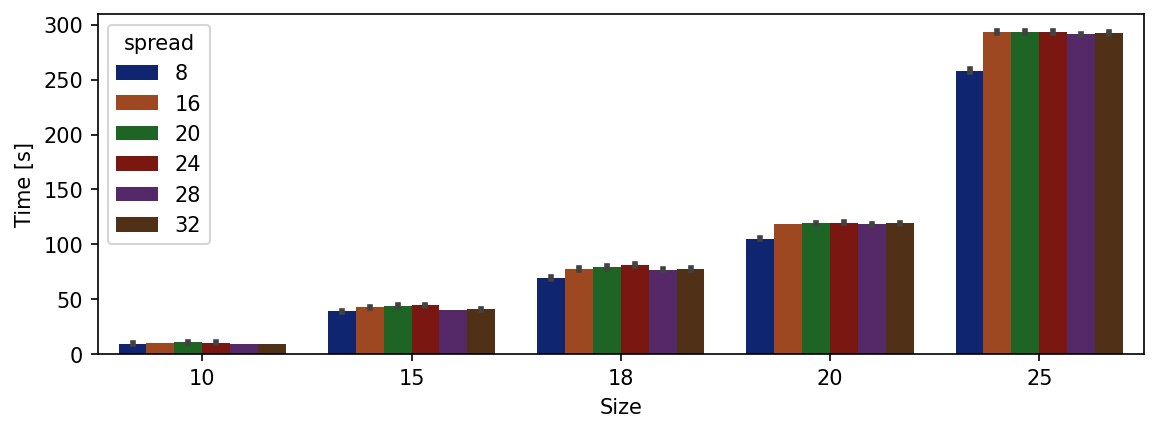

In [3]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
g = sns.barplot(
    data=lulesh_time,
    x="size", y="time", hue="spread",
    ci="sd", palette="dark",#, alpha=.6, height=6,
    ax=ax
)
#g.despine(left=True)
ax.set_xlabel("Size")
ax.set_ylabel("Time [s]")
#g.legend.set_title("")


In [41]:
#for size in [10,15,18,20,25,30]:
#    mean_full = lulesh_time.loc[(df['size'] == size) & (df['spread'] == 32)].mean()
#    mean_empty = lulesh_time.loc[(df['size'] == size) & (df['spread'] == 24)].mean()
#    ratio = mean_full / mean_empty
#    print(size, ratio['time'])

# NAS Benchmarks

In [4]:

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

data = []

for p in [1,2,4,8]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline_precision/nas_{p}/*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                size = f.split('_')[-2]
                benchmark = f.split('_')[-3]
                data.append([p, benchmark, size, float(line.split()[-1])])

df_baremetal = pd.DataFrame(data=data, columns=['p', 'benchmark', 'size', 'time'])
mean_baremetal = df_baremetal.groupby(['benchmark', 'size', 'p']).mean()['time']
print('CoV', df_baremetal.groupby(['benchmark', 'size', 'p']).std()['time'] / mean_baremetal)

print(df_baremetal.loc[(df_baremetal['size'] == 'W') & (df_baremetal['benchmark'] == 'bt') & (df_baremetal['p'] == 1)]['time'])

KeyError: 'time'

In [8]:

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

data = []

for p in [1,2,4,8]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_mc/nas_sarus_{p}/*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                size = f.split('_')[-2]
                benchmark = f.split('_')[-3]
                data.append([p, benchmark, size, float(line.split()[-1])])
                
nas_container = pd.DataFrame(data=data, columns=['p', 'benchmark', 'size', 'time'])
nas_container['type'] = nas_container.apply(lambda row: f"({row['benchmark'].upper()}, {row['size']})", axis=1)
nas_container.sort_values(by=['type'], inplace=True)
mean_container = nas_container.groupby(['benchmark', 'size', 'p']).mean()['time']
dev_container = nas_container.groupby(['benchmark', 'size', 'p']).std()['time']

print('Mean', mean_container)
print('CoV', nas_container.groupby(['benchmark', 'size', 'p']).std()['time'] / mean_container)
#print('Container/baremetal', mean_container/mean_baremetal)

mean_nas = nas_container.groupby(['benchmark', 'size', 'p']).mean().reset_index()
dev_nas = nas_container.groupby(['benchmark', 'size', 'p']).std().reset_index()
median_nas = nas_container.groupby(['benchmark', 'size', 'p']).median().reset_index()

Mean benchmark  size  p
bt         A     1    56.577188
                 4    12.404338
           W     1     1.973223
                 4     0.545870
cg         B     4    25.428294
                 8     7.170768
ep         B     1    18.759102
                 2     9.406570
                 4     4.773370
                 8     2.673881
           W     1     0.602891
                 2     0.310084
                 4     0.167499
                 8     0.099952
ft         B     1    38.786459
                 2    23.688358
                 4    13.111865
                 8     7.584424
           W     1     0.146355
                 2     0.089508
                 4     0.047142
                 8     0.027719
lu         A     1    25.896571
                 2    13.335083
                 4     6.869287
                 8     4.067591
mg         A     1     1.015738
           B     1     4.724846
           W     1     0.124478
Name: time, dtype: float64
CoV benchmark  size  

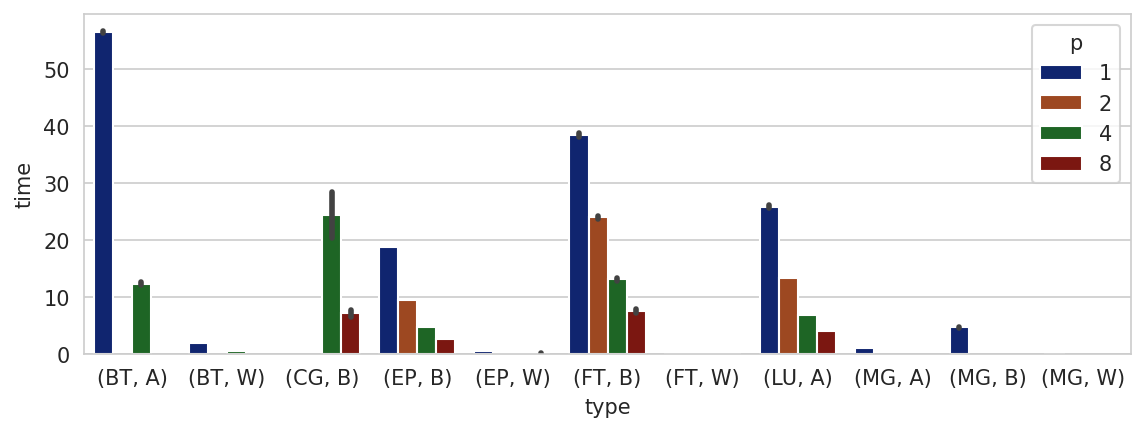

In [44]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
g = sns.barplot(
    data=nas_container,
    x="type", y="time", hue="p",
    ci="sd", palette="dark",#, alpha=.6, height=6,
    ax=ax
)
#g.despine(left=True)
#g.set_axis_labels("Size", "Time [s]")
#g.legend.set_title("")


In [7]:
mean_nas = nas_container.groupby(['benchmark', 'size', 'p']).mean().reset_index()
dev_nas = nas_container.groupby(['benchmark', 'size', 'p']).std().reset_index()
median_nas = nas_container.groupby(['benchmark', 'size', 'p']).median().reset_index()

# Co-location Data

In [13]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}

for dir in glob.glob(os.path.join(BASE_PATH, f'data/colocation_cpu_precision/lulesh/*')):
    
    name = os.path.basename(dir)
    
    app = name.split('_')[2]
    l_size = int(name.split('_')[1])
    bench_size = name.split('_')[3]
    
    for f in glob.glob(os.path.join(BASE_PATH, f'{dir}/nas_*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                data.append([l_size, bench_size, app, p_map[app][bench_size], float(line.split()[-1])])
                
colocated_nas = pd.DataFrame(data=data, columns=['lulesh_size', 'size', 'benchmark', 'p', 'time'])
print(colocated_nas)
#print(lulesh_time.loc[lulesh_time['size'] == 10]['time'])

mean_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).mean().reset_index()
dev_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).std().reset_index()
median_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).median().reset_index()

      lulesh_size size benchmark  p       time
0              20    A        bt  4  17.021830
1              20    A        bt  4  16.988172
2              20    A        bt  4  16.759310
3              20    A        bt  4  17.202335
4              20    A        bt  4  17.353254
...           ...  ...       ... ..        ...
3892           18    B        ep  2  11.872719
3893           18    B        ep  2  11.873238
3894           18    B        ep  2  11.873665
3895           18    B        ep  2  11.873699
3896           18    B        ep  2  11.873645

[3897 rows x 5 columns]


In [7]:
#print(colocated_nas)

mean_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).mean().reset_index()
dev_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).std().reset_index()
median_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).median().reset_index()
print(mean_colocated_nas)
#print(mean_container)

#print(mean_colocated / mean_container)

   benchmark size  p  lulesh_size       time
0         bt    A  4           15  14.920949
1         bt    A  4           18  15.917565
2         bt    A  4           20  16.115318
3         bt    A  4           25  16.885387
4         bt    W  1           15   2.340339
5         bt    W  1           18   2.410092
6         bt    W  1           20   2.418450
7         bt    W  1           25   2.463005
8         cg    B  8           15   5.971812
9         cg    B  8           18   6.094742
10        cg    B  8           20   6.145891
11        cg    B  8           25   6.280506
12        ep    B  2           15  10.995591
13        ep    B  2           18  11.548703
14        ep    B  2           20  11.598590
15        ep    B  2           25  11.744153
16        lu    A  4           15   8.205687
17        lu    A  4           18   8.593317
18        lu    A  4           20   8.474750
19        lu    A  4           25   8.700970
20        mg    A  1           15   1.171782
21        

In [22]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []



p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}

for dir in glob.glob(os.path.join(BASE_PATH, f'data/colocation_cpu_precision/lulesh/*')):
    
    name = os.path.basename(dir)
    
    app = name.split('_')[2]
    l_size = int(name.split('_')[1])
    bench_size = name.split('_')[3]
    
    for f in glob.glob(os.path.join(BASE_PATH, f'{dir}/lulesh_*.out')):
            
        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed time", fp):
                size = int(f.split('_')[-2])
                data.append([l_size, bench_size, app, float(line.split()[-2])])
                
colocated_lulesh = pd.DataFrame(data=data, columns=['size', 'benchmark_size', 'benchmark', 'time'])
avg_lulesh = normal_lulesh.groupby(['size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['size']).std().reset_index()
avg_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).mean().reset_index()
median_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).median().reset_index()
dev_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).std().reset_index()

print(avg_lulesh)
print(avg_colocated_lulesh)

#print(colocated_nas)
#print(lulesh_time.loc[lulesh_time['size'] == 10]['time'])


   size  spread        time
0    10    32.0    9.155678
1    15    32.0   40.764059
2    18    32.0   77.725878
3    20    32.0  119.237961
4    25    32.0  292.950306
    size benchmark benchmark_size        time
0     15        bt              A   40.677667
1     15        bt              W   40.504664
2     15        cg              B   41.492239
3     15        ep              B   40.180077
4     15        lu              A   40.562036
5     15        mg              A   40.973739
6     15        mg              W   40.720778
7     18        bt              A   77.959563
8     18        bt              W   78.059868
9     18        cg              B   78.779812
10    18        ep              B   78.234147
11    18        lu              A   78.112657
12    18        mg              A   78.771622
13    18        mg              W   78.483771
14    20        bt              A  119.864287
15    20        bt              W  120.322426
16    20        cg              B  122.234282
17  

In [11]:
avg_lulesh = normal_lulesh.groupby(['size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['size']).std().reset_index()
print(avg_lulesh)
print(median_lulesh)
print(dev_lulesh)

   size  spread        time
0    10    32.0    9.155678
1    15    32.0   40.621018
2    18    32.0   77.685812
3    20    32.0  119.035594
4    25    32.0  292.276421
   size  spread        time
0    10    32.0    9.100038
1    15    32.0   40.440631
2    18    32.0   77.152062
3    20    32.0  119.118239
4    25    32.0  292.189336
   size  spread      time
0    10     0.0  0.329754
1    15     0.0  0.490137
2    18     0.0  0.912380
3    20     0.0  0.464620
4    25     0.0  0.942006


In [10]:
avg_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).mean().reset_index()
median_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).median().reset_index()
dev_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).std().reset_index()
print(avg_colocated_lulesh)
print(median_colocated_lulesh)

    size benchmark benchmark_size        time
0     15        bt              A   40.696220
1     15        bt              W   40.504664
2     15        cg              B   41.492239
3     15        ep              B   40.180077
4     15        lu              A   40.541153
5     15        mg              A   43.002068
6     15        mg              W   40.720778
7     18        bt              A   77.959563
8     18        bt              W   78.059868
9     18        cg              B   78.779812
10    18        ep              B   78.234147
11    18        lu              A   78.112657
12    18        mg              W   78.495156
13    20        bt              A  119.864287
14    20        bt              W  120.322426
15    20        cg              B  122.169309
16    20        ep              B  119.450313
17    20        lu              A  119.938167
18    20        mg              W  120.441414
19    25        bt              A  295.908720
20    25        bt              W 

In [23]:

print(dev_lulesh)
print(dev_colocated_lulesh)

df1 = avg_colocated_lulesh.set_index('size')
print(df1)
df2 = avg_lulesh.set_index('size')
df3 = dev_lulesh.set_index('size')
df4 = dev_colocated_lulesh.set_index('size')
df1['dev'] = df4['time'].reindex(df1.index)
df1['original_time'] = df2['time'].reindex(df1.index)
df1['original_dev'] = df3['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']

df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

print(df1)
print(df2)

#print(df2)
#df1['slowdown'] = df1['time'] / df2['time']
# iterate over each group
#for group_name, df_group in avg_colocated_lulesh.groupby(['benchmark', 'benchmark_size']):

#    print(df_group)
#    df_group['slowdown'] = df_group['time'] / avg_lulesh['time']
    #for row_index, row in df_group.iterrows():
        #print(row)
#print(avg_colocated_lulesh)

   size  spread      time
0    10     0.0  0.329754
1    15     0.0  0.709925
2    18     0.0  0.792286
3    20     0.0  0.514777
4    25     0.0  1.184200
    size benchmark benchmark_size       time
0     15        bt              A   0.500435
1     15        bt              W   0.392733
2     15        cg              B   1.830090
3     15        ep              B   0.201297
4     15        lu              A   0.221592
5     15        mg              A   0.309420
6     15        mg              W   0.241332
7     18        bt              A   0.393864
8     18        bt              W   0.454771
9     18        cg              B   0.540605
10    18        ep              B   0.743515
11    18        lu              A   0.420457
12    18        mg              A   0.337547
13    18        mg              W   0.673686
14    20        bt              A   0.735505
15    20        bt              W   0.720762
16    20        cg              B   3.765780
17    20        ep              B 

In [24]:
df3 = mean_colocated_nas.set_index(['benchmark', 'size', 'p'])
print(df3)
df4 = mean_nas.set_index(['benchmark', 'size', 'p'])
df10 = dev_nas.set_index(['benchmark', 'size', 'p'])
df11 = dev_colocated_nas.set_index(['benchmark', 'size', 'p'])
#print(df4)
df3['original_dev'] = df10['time'].reindex(df3.index)
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['dev'] = df11['time'].reindex(df3.index)
df3['slowdown_dev'] = np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)
print(df3)

                  lulesh_size       time
benchmark size p                        
bt        A    4           15  15.152626
               4           18  15.917565
               4           20  16.115318
               4           25  16.826005
          W    1           15   2.340339
               1           18   2.410092
               1           20   2.418450
               1           25   2.463005
cg        B    8           15   5.971812
               8           18   6.094742
               8           20   6.145455
               8           25   6.244260
ep        B    2           15  10.995591
               2           18  11.548703
               2           20  11.598590
               2           25  11.748723
lu        A    4           15   8.287576
               4           18   8.593317
               4           20   8.527597
               4           25   8.761068
mg        A    1           15   1.153538
               1           18   1.164391
               1

In [25]:
df5 = df1.reset_index().rename(columns={"size": "lulesh_size"})
df6 = df3.reset_index().rename(columns={"size": "benchmark_size"})

df5 = df5.set_index(['benchmark', 'benchmark_size', 'lulesh_size'])
df6 = df6.set_index(['benchmark', 'benchmark_size', 'lulesh_size'])
print(df5)
print('-')
print(df6)

df5['nas_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['nas_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
print(df5)
df5.reset_index(inplace=True)

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}
df5['p'] = df5[['benchmark', 'benchmark_size']].apply(lambda x: p_map[x['benchmark']][x['benchmark_size']], axis=1)
#df5['p'] = p_map[df5['benchmark']][df5['bench_size']]
df5['type'] = df5.apply(lambda row: f"({row['benchmark'].upper()}, {row['benchmark_size']}, {row['p']})", axis=1)
df5.sort_values(by=['type'], inplace=True)
print(df5)

                                            time        dev  original_time  \
benchmark benchmark_size lulesh_size                                         
bt        A              15            40.677667   0.500435      40.764059   
          W              15            40.504664   0.392733      40.764059   
cg        B              15            41.492239   1.830090      40.764059   
ep        B              15            40.180077   0.201297      40.764059   
lu        A              15            40.562036   0.221592      40.764059   
mg        A              15            40.973739   0.309420      40.764059   
          W              15            40.720778   0.241332      40.764059   
bt        A              18            77.959563   0.393864      77.725878   
          W              18            78.059868   0.454771      77.725878   
cg        B              18            78.779812   0.540605      77.725878   
ep        B              18            78.234147   0.743515     

In [26]:
print(df5)
df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_nas_slowdown'] = (df5['nas_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_nas_slowdown_dev'] = df5['nas_slowdown_dev']*100
print(df5)

   benchmark benchmark_size  lulesh_size        time        dev  \
0         bt              A           15   40.677667   0.500435   
21        bt              A           25  295.591566   1.597424   
14        bt              A           20  119.864287   0.735505   
7         bt              A           18   77.959563   0.393864   
1         bt              W           15   40.504664   0.392733   
15        bt              W           20  120.322426   0.720762   
22        bt              W           25  295.647019   1.425129   
8         bt              W           18   78.059868   0.454771   
16        cg              B           20  122.234282   3.765780   
23        cg              B           25  297.945357   1.271533   
2         cg              B           15   41.492239   1.830090   
9         cg              B           18   78.779812   0.540605   
10        ep              B           18   78.234147   0.743515   
3         ep              B           15   40.180077   0.20129

In [32]:
df5_modified = df5.drop(df5.loc[df5['type'] == '(MG, A, 1)'].index)

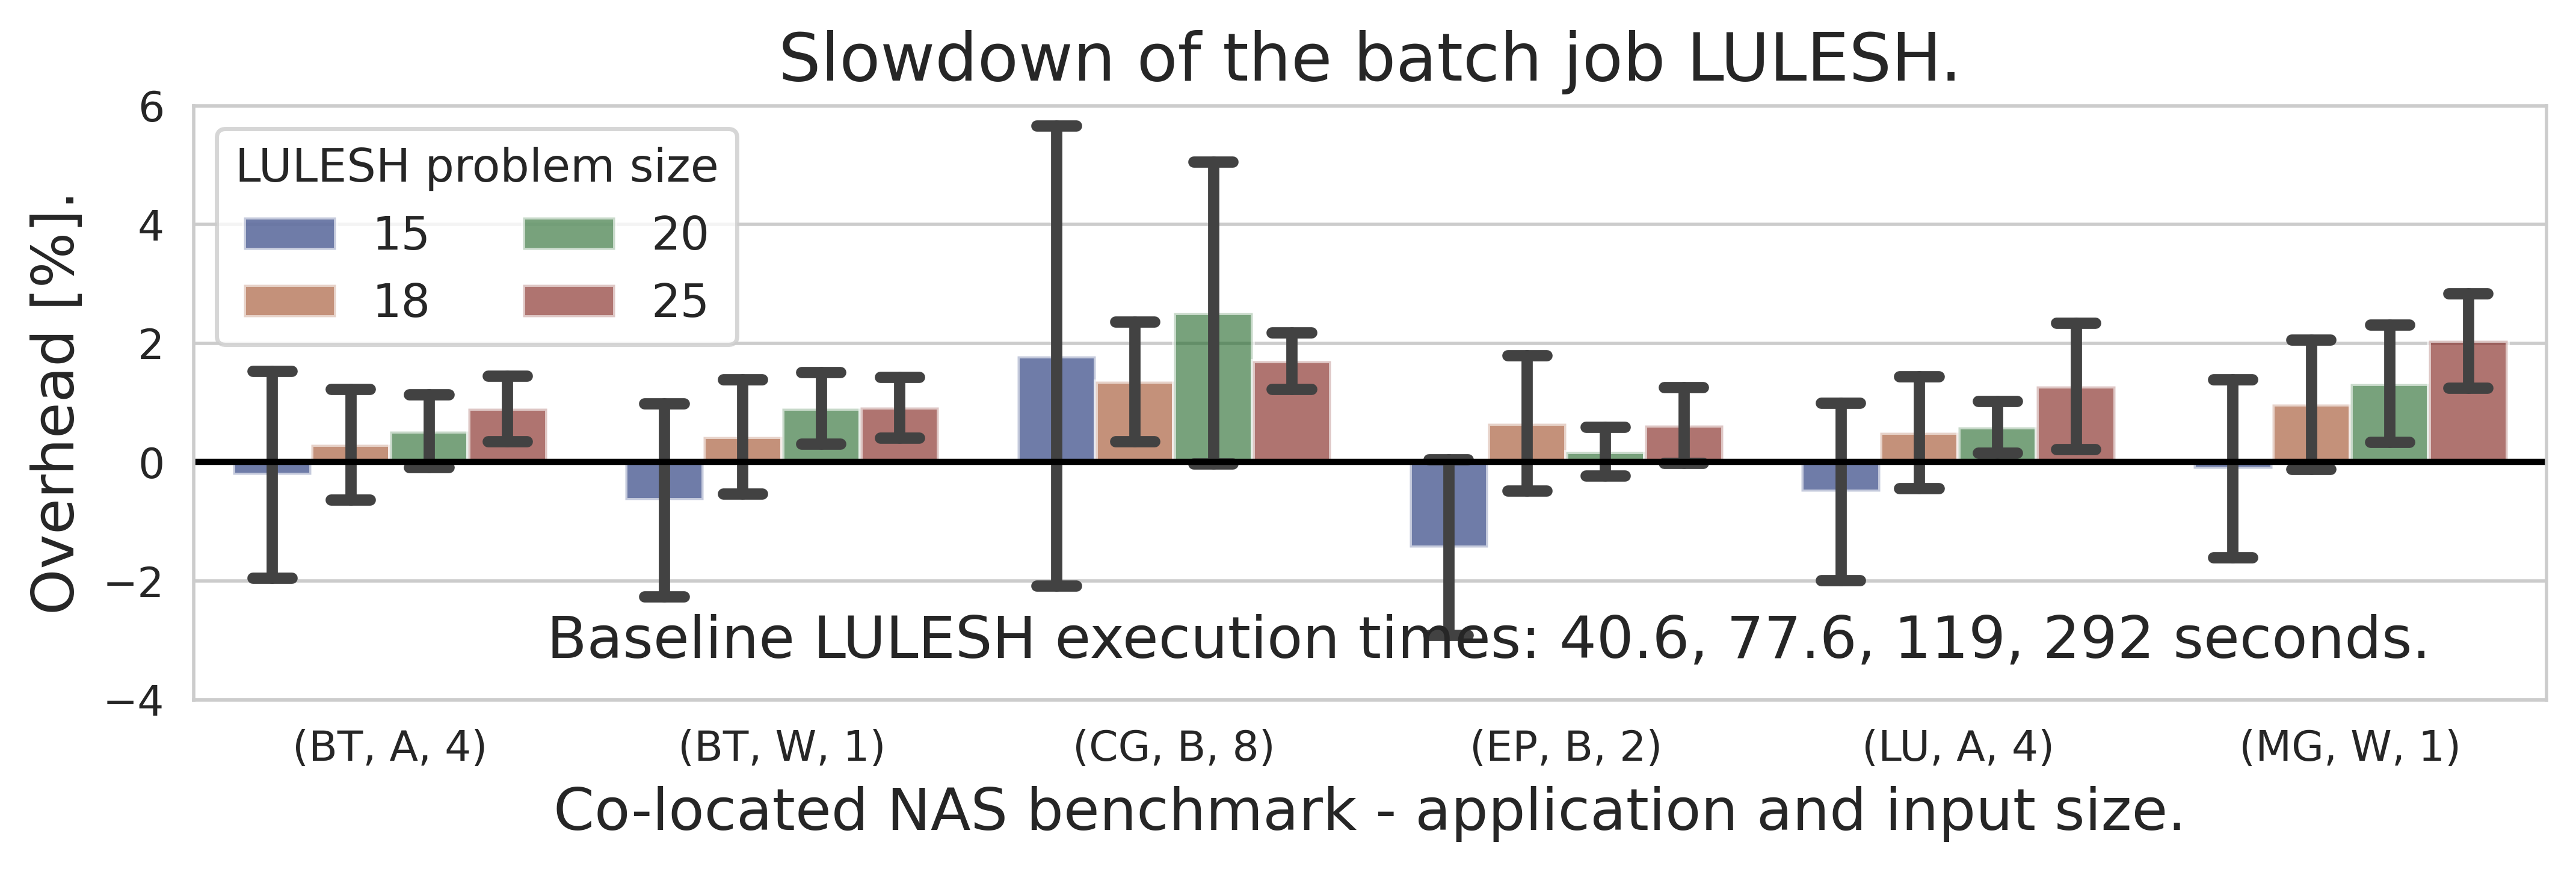

In [33]:

def barplot_err(x, y, xerr=None, yerr=None, data=None, **kwargs):

    _data = []
    for _i in data.index:

        _data_i = pd.concat([data.loc[_i:_i]]*3, ignore_index=True, sort=False)
        _row = data.loc[_i]
        if xerr is not None:
            _data_i[x] = [_row[x]-_row[xerr], _row[x], _row[x]+_row[xerr]]
        if yerr is not None:
            _data_i[y] = [_row[y]-_row[yerr], _row[y], _row[y]+_row[yerr]]
        _data.append(_data_i)

    _data = pd.concat(_data, ignore_index=True, sort=False)

    _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)

    return _ax


sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5_modified,
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax, yerr=df5_modified['slowdown_dev']*1
#)

g = barplot_err(y="rescaled_slowdown", x="type", yerr="rescaled_slowdown_dev", hue="lulesh_size",
                data=df5_modified,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located NAS benchmark - application and input size.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='LULESH problem size', ncol=2, fontsize=11,title_fontsize=11)
#plt.legend.set_title('LULESH problem size',prop={'fontsize':14})
g.set_ylim([-4,6])
g.axhline(y=0, color='black', linestyle='-')


def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    print(data)
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)
#ax.map_dataframe(errplot, "type", "slowdown", "slowdown_dev")


plt.annotate("Baseline LULESH execution times: 40.6, 77.6, 119, 292 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(0.4, -3.3), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("colocation_cpu_lulesh.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

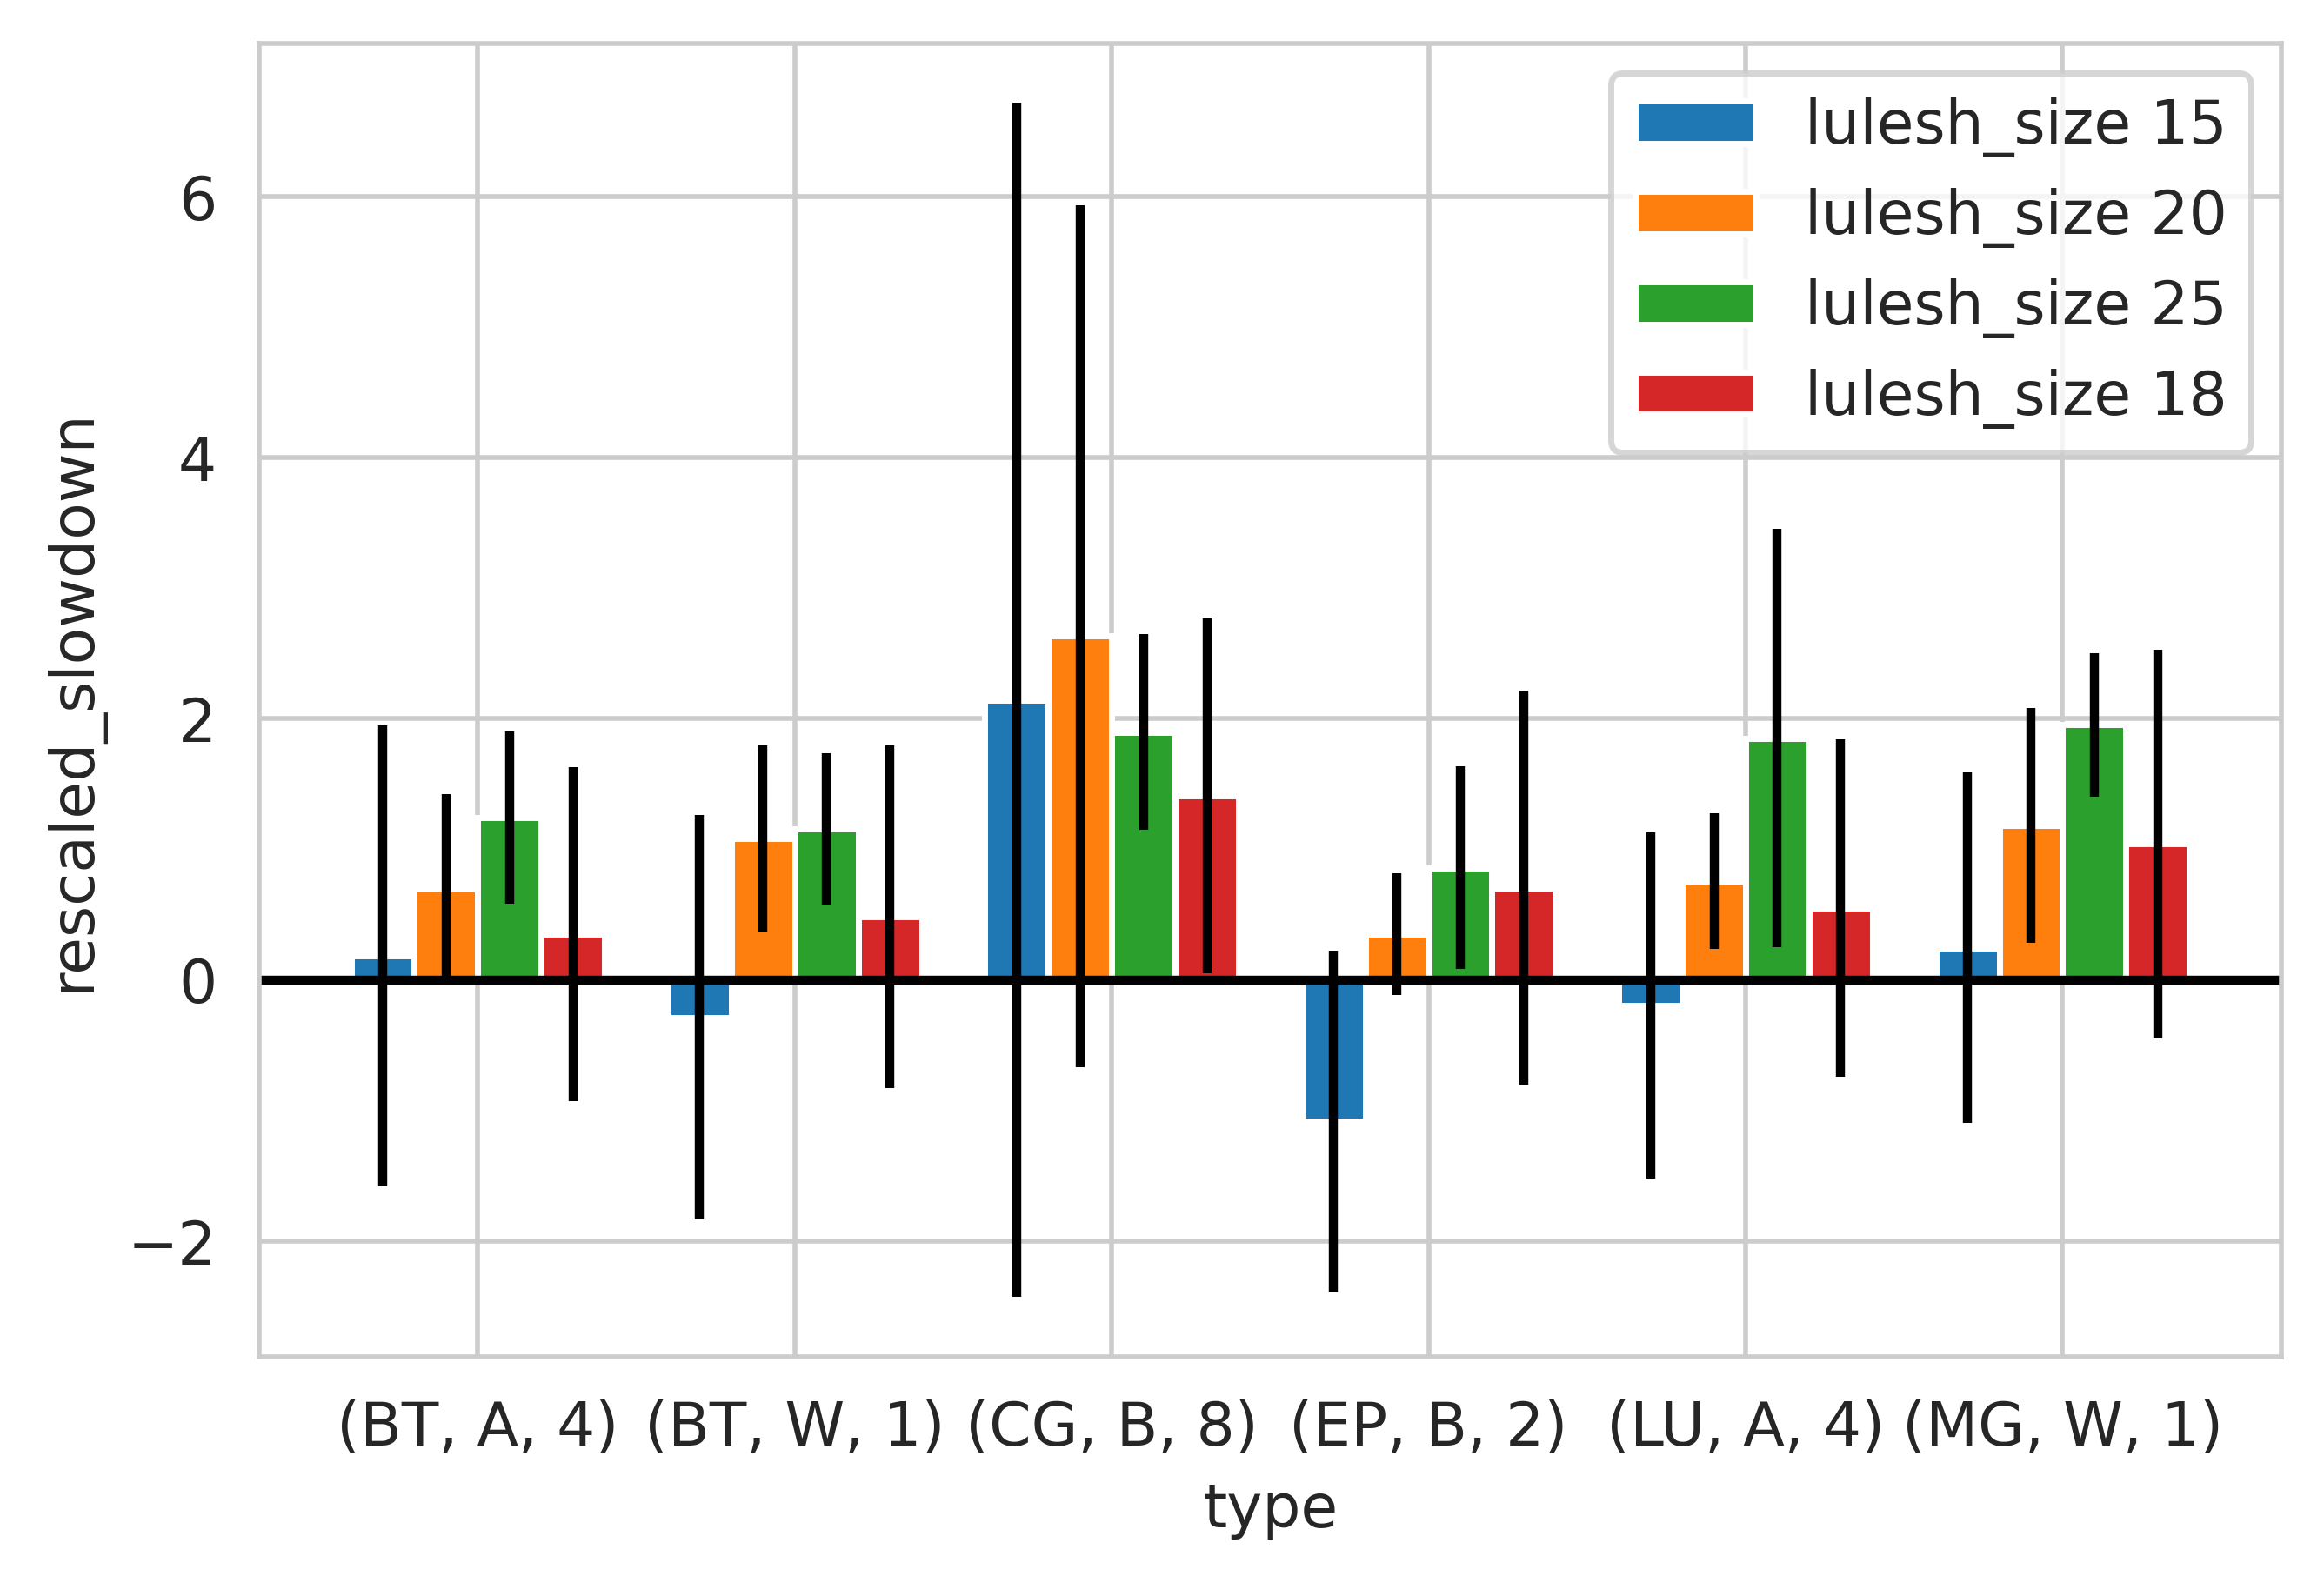

In [132]:


def grouped_barplot(df, cat,subcat, val , err):
    plt.clf()
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    plt.axhline(y=.0, color='black', linestyle='-')
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    #plt.ylim([0.95, 1.08])
    plt.legend()
    plt.show()
    
    
cat = "type"
subcat = "lulesh_size"
val = "rescaled_slowdown"
err = "rescaled_slowdown_dev"

# call the function with df from the question
grouped_barplot(df5_modified, cat, subcat, val, err )

In [1]:

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df5_modified,
#    x="type", y="nas_slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #, alpha=.6, height=6,
#    ax=ax
#)
g = barplot_err(y="rescaled_nas_slowdown", x="type", yerr="rescaled_nas_slowdown_dev",
                hue="lulesh_size", data=df5_modified,palette="dark", alpha=.6, capsize=0.1)

g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the co-located FaaS-like MPI application.',fontsize=16)
g.legend().set_visible(False)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-40, 45])
g.set_xlabel('Co-located NAS benchmark - application and input size.',fontsize=14)


plt.annotate("Baseline execution times: 12.3, 2, 7.2, 9.4, 6.8, 0.13 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(-0.45, -39), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(0.1, 0),  #xycoords='data',
            xytext=(1.7, -35),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(1, 0),  #xycoords='data',
            xytext=(1.9, -35),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(2.1, -25),  #xycoords='data',
            xytext=(2.1, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(3.2, 0),  #xycoords='data',
            xytext=(2.4, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4.2, 0),  #xycoords='data',
            xytext=(2.7, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(5.2, 0),  #xycoords='data',
            xytext=(3.1, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("colocation_cpu_nas.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

SyntaxError: invalid syntax (3097661831.py, line 63)

In [49]:

data = []
for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_mc/milc_64/milc_32/milc_*.out')):

    with open(f, 'r') as fp:
        for line in lines_that_start_with("Elapsed total time", fp):
            size = int(f.split('_')[-2])
            data.append([32, size, float(line.split()[-1])])
            
normal_milc_mc = pd.DataFrame(data=data, columns=['ranks_per_node', 'size', 'time'])
normal_milc_mc['system'] = 'daint-mc'
normal_milc_mc['type'] = 'baseline'
normal_milc_mc['benchmark'] = 'milc'
normal_milc_mc['application'] = 'milc'
normal_milc_mc['benchmark-type'] = normal_milc_mc.apply(lambda row: f"({row['benchmark'].upper()}, {row['application'].upper()}, {row['size']})", axis=1)
normal_milc_mc['ranks'] = 64
normal_milc_mc['nodes'] = 2

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []


p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}

for dir in glob.glob(os.path.join(BASE_PATH, f'data/colocation_cpu_precision/milc/*')):
    
    name = os.path.basename(dir)
    
    app = name.split('_')[2]
    l_size = int(name.split('_')[1])
    bench_size = name.split('_')[3]
    
    for f in glob.glob(os.path.join(BASE_PATH, f'{dir}/milc_*.out')):
            
        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed total time", fp):
                size = int(f.split('_')[-2])
                data.append([l_size, bench_size, app, float(line.split()[-1])])

colocated_lulesh = pd.DataFrame(data=data, columns=['size', 'benchmark_size', 'benchmark', 'time'])
avg_lulesh = normal_milc_mc.groupby(['size']).mean().reset_index()
median_lulesh = normal_milc_mc.groupby(['size']).median().reset_index()
dev_lulesh = normal_milc_mc.groupby(['size']).std().reset_index()
avg_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).mean().reset_index()
median_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).median().reset_index()
dev_colocated_lulesh = colocated_lulesh.groupby(['size', 'benchmark', 'benchmark_size']).std().reset_index()
print(avg_lulesh)
print(avg_colocated_lulesh)
print(median_lulesh)
print(avg_colocated_lulesh)

   size  ranks_per_node        time  ranks  nodes
0    32            32.0   87.155905   64.0    2.0
1    64            32.0  168.985498   64.0    2.0
2    96            32.0  288.414344   64.0    2.0
3   128            32.0  409.516316   64.0    2.0
    size benchmark benchmark_size        time
0     32        bt              A   92.263732
1     32        bt              W   87.610899
2     32        cg              B   89.759592
3     32        ep              B   86.460632
4     32        lu              A   86.438093
5     32        mg              A   87.973872
6     32        mg              W   89.560359
7     64        bt              A  178.498148
8     64        bt              W  166.617567
9     64        cg              B  170.556660
10    64        ep              B  163.159834
11    64        lu              A  162.166209
12    64        mg              A  165.473741
13    64        mg              W  167.630264
14    96        bt              A  253.647894
15    96      

In [36]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}

for dir in glob.glob(os.path.join(BASE_PATH, f'data/colocation_cpu_precision/milc/*')):
    
    name = os.path.basename(dir)
    
    app = name.split('_')[2]
    l_size = int(name.split('_')[1])
    bench_size = name.split('_')[3]
    
    for f in glob.glob(os.path.join(BASE_PATH, f'{dir}/nas_*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                data.append([l_size, bench_size, app, p_map[app][bench_size], float(line.split()[-1])])
                
colocated_nas = pd.DataFrame(data=data, columns=['lulesh_size', 'size', 'benchmark', 'p', 'time'])
print(colocated_nas)
#print(lulesh_time.loc[lulesh_time['size'] == 10]['time'])

mean_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).mean().reset_index()
dev_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).std().reset_index()
median_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'p', 'lulesh_size']).median().reset_index()

      lulesh_size size benchmark  p      time
0              64    A        mg  1  1.397071
1              64    A        mg  1  1.389837
2              64    A        mg  1  1.403283
3              64    A        mg  1  1.403107
4              64    A        mg  1  1.406551
...           ...  ...       ... ..       ...
7807           32    W        mg  1  0.164297
7808           32    W        mg  1  0.171885
7809           32    W        mg  1  0.171457
7810           32    W        mg  1  0.187777
7811           32    W        mg  1  0.171629

[7812 rows x 5 columns]


In [41]:
print(dev_lulesh)
print(dev_colocated_lulesh)

df1 = avg_colocated_lulesh.set_index('size')
print(df1)
df2 = avg_lulesh.set_index('size')
df3 = dev_lulesh.set_index('size')
df4 = dev_colocated_lulesh.set_index('size')
df1['dev'] = df4['time'].reindex(df1.index)
df1['original_time'] = df2['time'].reindex(df1.index)
df1['original_dev'] = df3['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']

df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

print(df1)
print(df2)

df3 = mean_colocated_nas.set_index(['benchmark', 'size', 'p'])
print(df3)
df4 = mean_nas.set_index(['benchmark', 'size', 'p'])
df10 = dev_nas.set_index(['benchmark', 'size', 'p'])
df11 = dev_colocated_nas.set_index(['benchmark', 'size', 'p'])
#print(df4)
df3['original_dev'] = df10['time'].reindex(df3.index)
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['dev'] = df11['time'].reindex(df3.index)
df3['slowdown_dev'] = np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)
print(df3)

df5 = df1.reset_index().rename(columns={"size": "lulesh_size"})
df6 = df3.reset_index().rename(columns={"size": "benchmark_size"})

df5 = df5.set_index(['benchmark', 'benchmark_size', 'lulesh_size'])
df6 = df6.set_index(['benchmark', 'benchmark_size', 'lulesh_size'])
print(df5)
print('-')
print(df6)

df5['nas_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['nas_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
print(df5)
df5.reset_index(inplace=True)

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}
df5['p'] = df5[['benchmark', 'benchmark_size']].apply(lambda x: p_map[x['benchmark']][x['benchmark_size']], axis=1)
#df5['p'] = p_map[df5['benchmark']][df5['bench_size']]
df5['type'] = df5.apply(lambda row: f"({row['benchmark'].upper()}, {row['benchmark_size']}, {row['p']})", axis=1)
df5.sort_values(by=['type'], inplace=True)
print(df5)

print(df5)
df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_nas_slowdown'] = (df5['nas_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_nas_slowdown_dev'] = df5['nas_slowdown_dev']*100
print(df5)

df5_modified = df5.drop(df5.loc[df5['type'] == '(MG, A, 1)'].index)

   size  ranks_per_node       time  ranks  nodes
0    32             0.0   1.820911    0.0    0.0
1    64             0.0   6.175914    0.0    0.0
2    96             0.0  33.204462    0.0    0.0
3   128             0.0  47.504161    0.0    0.0
    size benchmark benchmark_size       time
0     32        bt              A  22.851391
1     32        bt              W   1.162911
2     32        cg              B   2.488727
3     32        ep              B   1.841430
4     32        lu              A   0.165291
5     32        mg              A   1.127458
6     32        mg              W   1.014670
7     64        bt              A  51.771556
8     64        bt              W   2.782889
9     64        cg              B   2.080400
10    64        ep              B   4.675944
11    64        lu              A   1.462746
12    64        mg              A   2.314296
13    64        mg              W   1.013419
14    96        bt              A   0.691634
15    96        bt              W  

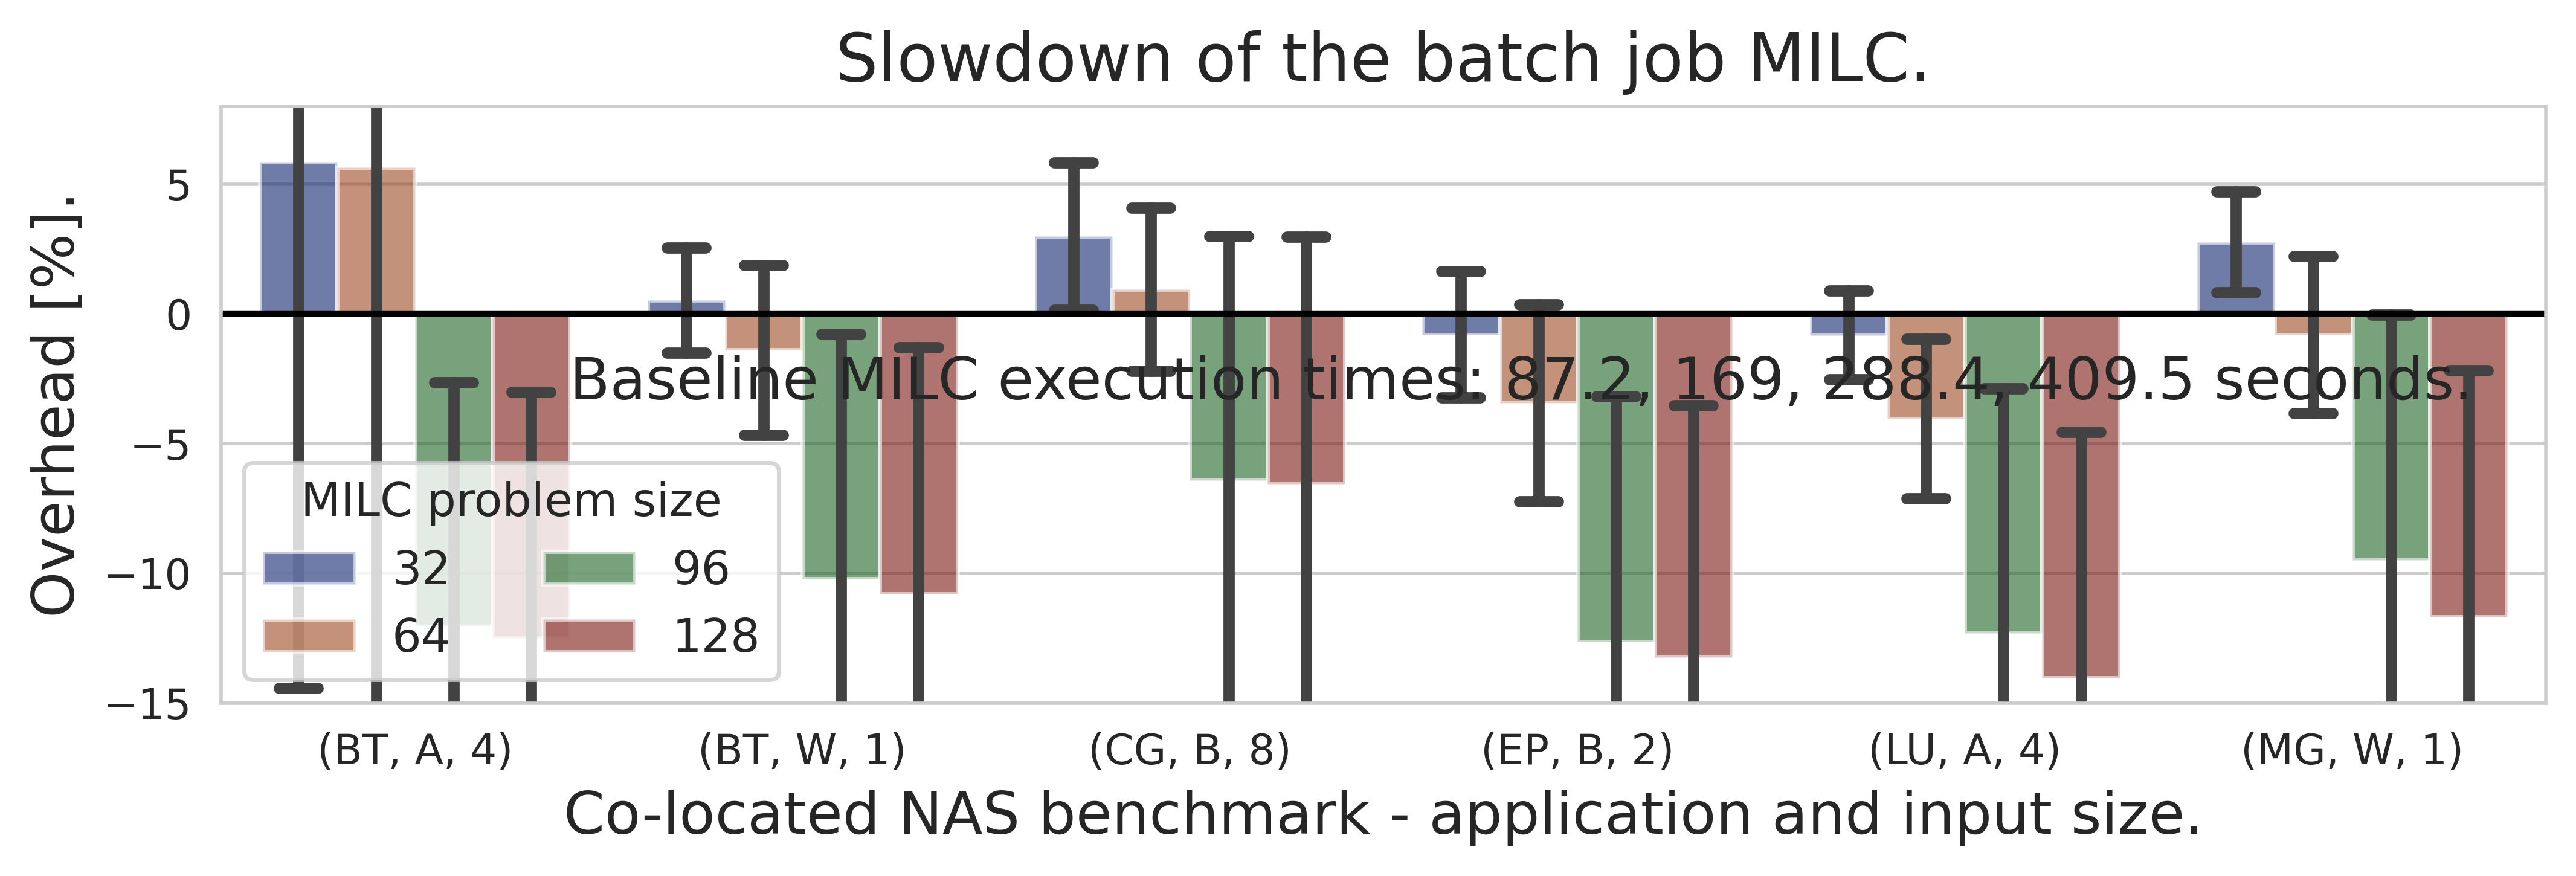

In [47]:

def barplot_err(x, y, xerr=None, yerr=None, data=None, **kwargs):

    _data = []
    for _i in data.index:

        _data_i = pd.concat([data.loc[_i:_i]]*3, ignore_index=True, sort=False)
        _row = data.loc[_i]
        if xerr is not None:
            _data_i[x] = [_row[x]-_row[xerr], _row[x], _row[x]+_row[xerr]]
        if yerr is not None:
            _data_i[y] = [_row[y]-_row[yerr], _row[y], _row[y]+_row[yerr]]
        _data.append(_data_i)

    _data = pd.concat(_data, ignore_index=True, sort=False)

    _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)

    return _ax


sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5_modified,
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax, yerr=df5_modified['slowdown_dev']*1
#)

g = barplot_err(y="rescaled_slowdown", x="type", yerr="rescaled_slowdown_dev", hue="lulesh_size",
                data=df5_modified,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located NAS benchmark - application and input size.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2, fontsize=11,title_fontsize=11)
#plt.legend.set_title('LULESH problem size',prop={'fontsize':14})
g.set_ylim([-15,8])
g.axhline(y=0, color='black', linestyle='-')


def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    print(data)
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)
#ax.map_dataframe(errplot, "type", "slowdown", "slowdown_dev")


plt.annotate("Baseline MILC execution times: 87.2, 169, 288.4, 409.5 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(0.4, -3.3), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("colocation_cpu_milc.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)